# Init

In [1]:
import json

def extract_elements_from_json(json_file_path):
    with open(json_file_path, 'r') as f:
        data = json.load(f)
    
    datasets = []
    models = []
    filters = []
    metrics = []
    
    for dataset_name, dataset_data in data.items():
        datasets.append(dataset_name)
        
        for model_name, model_data in dataset_data.items():
            if model_name not in models:
                models.append(model_name)
            
            # Collect all filter types
            if model_data:
                for filter_type in model_data.keys():
                    if filter_type not in filters:
                        filters.append(filter_type)
                    
                    # Extract metrics from each filter
                    if model_data[filter_type]:
                        for metric_name in model_data[filter_type].keys():
                            if metric_name not in metrics:
                                metrics.append(metric_name)
    
    return models, datasets, filters, metrics

# Updated usage:
models, datasets, filters, metrics = extract_elements_from_json("../model_comparison copy.json")
models.remove("DT")
print("Models:", models)
print("Datasets:", datasets)
print("Filters:", filters)
print("Metrics:", metrics)

small_datasets = ["zcta5", "aerowaythingnodesorted", "craftwaysorted", "arealm", "emergencythingwaysorted", "historicthingwaysorted", "aerowaythingwaysorted"]
big_datasets = list(set(datasets) - set(small_datasets))

Models: ['Histogram', 'RTree', 'KNN', 'NN', 'RF', 'XGB']
Datasets: ['powerthingwaysorted', 'yago2', 'emergencythingwaysorted', 'cyclewaythingwaysorted', 'arealm', 'zcta5', 'historicthingwaysorted', 'craftwaysorted', 'aerowaythingnodesorted', 'areawater', 'barrierthingwaysorted', 'leisurewaysorted', 'aerowaythingwaysorted', 'powerthingnodesorted']
Filters: ['intersect', 'contain', 'distance']
Metrics: ['mae', 'mape', 'avg_time_ms', 'build_time_s', 'model_size_mb']


In [2]:
import pandas as pd

def create_metrics_dataframe(models, datasets, filters, metric, json_file_path):
    with open(json_file_path, 'r') as f:
        data = json.load(f)
    
    index = [f"{dataset}_{filter_type}" for dataset in datasets for filter_type in filters]
    
    result_df = pd.DataFrame(index=index, columns=models)
    
    for model in models:
        for dataset in datasets:
            for filter_type in filters:
                try:
                    value = data[dataset][model][filter_type][metric]
                    result_df.loc[f"{dataset}_{filter_type}", model] = value
                except (KeyError, TypeError):
                    result_df.loc[f"{dataset}_{filter_type}", model] = None
    
    return result_df

In [3]:
import pandas as pd
from autorank import autorank, plot_stats, create_report, latex_report, latex_table
import matplotlib.pyplot as plt

def create_nemenyi_diagram(df, metric_name, filename=None, reverse=False):
    """
    Generate a Nemenyi test diagram with Friedman test using autorank
    
    Args:
        df (pd.DataFrame): Dataframe with models as columns and dataset_filter combinations as rows
        metric_name (str): Name of the metric being visualized (for the title)
        filename (str, optional): Filename to save the diagram. If None, just displays it.
        reverse (bool): Set to True if lower values are better (like error metrics)
                        Set to False if higher values are better (like accuracy)
    
    Returns:
        dict: Dictionary with the results of the statistical tests
    """
    # Make sure we have numeric data
    numeric_df = df.apply(pd.to_numeric, errors='coerce')
    
    result = autorank(
        numeric_df,
        alpha=0.05,
        verbose=False,
        order='descending' if not reverse else 'ascending'
    )
    
    # Create the plot
    plt.figure(figsize=(10, 6))
    
    # Plot the statistics
    ax = plot_stats(result, allow_insignificant=True)
    
    if hasattr(result, 'cd') and result.cd is not None:
        ax.annotate(f"CD = {result.cd:.3f}", 
                   xy=(0.95, 0.95),
                   xycoords='axes fraction',
                   ha='right',
                   va='top',
                   fontsize=9,
                   bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))
    
    if metric_name is not None:
        plt.title(f'Nemenyi Test Diagram ({metric_name})')
        
    plt.tight_layout()
    
    if filename:
        plt.savefig(filename, dpi=300, bbox_inches='tight')
    
    plt.show()
    
    return result

In [4]:
def df_to_matlab_critical_difference(df, method_name='methods', matrix_name='result_matrix', function_name='criticaldifference', alpha=0.05, multiply_by=1.0):
    """
    Convert a pandas DataFrame to MATLAB code for critical difference analysis.
    
    Args:
        df (pd.DataFrame): DataFrame to convert
        method_name (str): Name of the MATLAB variable for methods
        matrix_name (str): Name of the MATLAB variable for the matrix
        function_name (str): Name of the MATLAB function to call
        alpha (float): Alpha value for the critical difference function
        multiply_by (float): Multiplier for values in the function call
        
    Returns:
        str: MATLAB code defining methods, matrix, and function call
    """
    # Create MATLAB code for methods list
    methods_list = list(df.columns)
    methods_matlab = f"% list of compared approaches\n{method_name} =" + "{"
    methods_matlab += ",".join([f"'{method}'" for method in methods_list])
    methods_matlab += "};\n"
    
    # Create MATLAB code for results matrix
    matrix_matlab = f"% results (each row represents a dataset)\n{matrix_name} = ["
    
    # Process each row of the dataframe
    rows = []
    for _, row in df.iterrows():
        # Format values, replacing NaN with 'NaN'
        row_values = []
        for val in row:
            if pd.isna(val):
                row_values.append("NaN")
            else:
                row_values.append(f"{val:.4f}" if isinstance(val, (int, float)) else str(val))
        
        # Join values with commas and add to rows list
        rows.append(", ".join(row_values))
    
    # Join rows with semicolons and line breaks
    matrix_matlab += ";\n    ".join(rows)
    matrix_matlab += "];\n\n"
    
    # Create function call
    # In your example, it seems like there might be a specific column selection (1,2,3,4,5,6,7,8,10)
    # I'll make it general but allow customization
    column_indices = ", ".join([str(i+1) for i in range(len(df.columns))])
    
    # Handling the operation inside the function call (1- (roc_volume*0.01))
    func_call = f"{function_name}(1- ({matrix_name}(:,[{column_indices}])*{multiply_by}),{method_name},{alpha});"
    
    # Combine all parts
    matlab_code = methods_matlab + matrix_matlab + func_call
    
    return matlab_code

In [5]:
df = create_metrics_dataframe(
    models=models,
    datasets=datasets,
    filters=["intersect"],
    metric="mae",
    json_file_path="../model_comparison copy.json"
)

df

,Histogram,RTree,KNN,NN,RF,XGB
powerthingwaysorted_intersect,4956.996357,8848.545322,12449.321522,14686.017112,4036.763728,12534.339844
yago2_intersect,42363.255769,19192.006836,5264.34337,6098.008047,2415.382949,5774.849121
emergencythingwaysorted_intersect,473.719338,4587.459043,2495.428563,2231.626124,467.785334,752.174255
cyclewaythingwaysorted_intersect,1839.621051,9123.383666,7902.839123,8117.051643,1630.391177,4174.718262
arealm_intersect,216.219381,1642.605304,604.190484,960.305984,170.853686,159.031769
zcta5_intersect,101.210256,445.122264,216.083994,298.383512,98.292949,163.404846
historicthingwaysorted_intersect,776.415417,5735.416938,3615.251067,2541.190178,827.391357,1259.622559
craftwaysorted_intersect,203.833293,1244.864803,604.326068,829.540748,176.713543,173.883713
aerowaythingnodesorted_intersect,168.50447,722.697601,348.012899,720.350258,252.626437,216.570801
areawater_intersect,870.112803,5168.130738,4802.73153,2002.209213,839.960516,1180.204102


/tmp/ipykernel_2669909/1463458161.py:47: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


<Figure size 1000x600 with 0 Axes>

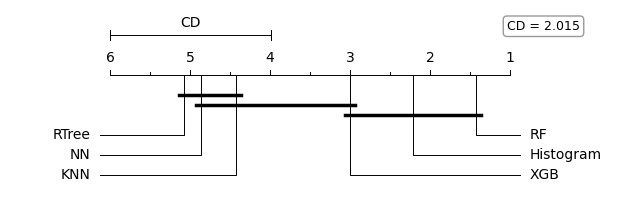

The statistical analysis was conducted for 6 populations with 14 paired samples.
The family-wise significance level of the tests is alpha=0.050.
We rejected the null hypothesis that the population is normal for the populations Histogram (p=0.002), XGB (p=0.003), NN (p=0.000), and RTree (p=0.004). Therefore, we assume that not all populations are normal.
Because we have more than two populations and the populations and some of them are not normal, we use the non-parametric Friedman test as omnibus test to determine if there are any significant differences between the median values of the populations. We use the post-hoc Nemenyi test to infer which differences are significant. We report the median (MD), the median absolute deviation (MAD) and the mean rank (MR) among all populations over the samples. Differences between populations are significant, if the difference of the mean rank is greater than the critical distance CD=2.015 of the Nemenyi test.
We reject the null hypothesis (p=0.000

In [6]:
result = create_nemenyi_diagram(df, None, None, reverse=True)
create_report(result)
# latex_report(result)
# latex_table(result)

In [7]:
matlab_code = df_to_matlab_critical_difference(
    df,
    method_name='methods',
    matrix_name='roc_volume',
    function_name='criticaldifference',
    alpha=0.05,
    multiply_by=0.01
)

print(matlab_code)

with open("critical_difference_analysis.m", "w") as f:
    f.write(matlab_code)

% list of compared approaches
methods ={'Histogram','RTree','KNN','NN','RF','XGB'};
% results (each row represents a dataset)
roc_volume = [4956.9964, 8848.5453, 12449.3215, 14686.0171, 4036.7637, 12534.3398;
    42363.2558, 19192.0068, 5264.3434, 6098.0080, 2415.3829, 5774.8491;
    473.7193, 4587.4590, 2495.4286, 2231.6261, 467.7853, 752.1743;
    1839.6211, 9123.3837, 7902.8391, 8117.0516, 1630.3912, 4174.7183;
    216.2194, 1642.6053, 604.1905, 960.3060, 170.8537, 159.0318;
    101.2103, 445.1223, 216.0840, 298.3835, 98.2929, 163.4048;
    776.4154, 5735.4169, 3615.2511, 2541.1902, 827.3914, 1259.6226;
    203.8333, 1244.8648, 604.3261, 829.5407, 176.7135, 173.8837;
    168.5045, 722.6976, 348.0129, 720.3503, 252.6264, 216.5708;
    870.1128, 5168.1307, 4802.7315, 2002.2092, 839.9605, 1180.2041;
    8490.1191, 16561.2147, 23391.1786, 23237.8787, 4564.9015, 20810.9766;
    10648.6112, 16165.6451, 24634.2846, 29935.4604, 5874.8881, 22621.2988;
    800.0944, 3645.6477, 3075.7286, 2768

In [8]:
import sys
import io
from contextlib import redirect_stdout
from autorank import create_report

def save_autorank_report(result, filename):
    """
    Captures and saves the output of autorank's create_report function to a file
    
    Args:
        result: The autorank result object
        filename: The file to save the report to
    """
    # Create a StringIO object to capture the printed output
    f = io.StringIO()
    
    # Redirect stdout to our StringIO object
    with redirect_stdout(f):
        create_report(result)
        latex_report(result)
        latex_table(result)
    
    # Get the printed content
    report_content = f.getvalue()
    
    # Write the content to a file
    with open(filename, 'w') as output_file:
        output_file.write(report_content)
    
    return report_content  # Optional: return the content as well

# Real WORK

In [9]:
import os

def nemenyi_diagrams(models, filters, filters_name, datasets, metric, json_file_path, output_dir):
    df = create_metrics_dataframe(
        models=models,
        datasets=datasets,
        filters=filters,
        metric=metric,
        json_file_path=json_file_path
    )

    # Rename 'NN' column to 'MLP'
    df = df.rename(columns={'NN': 'MLP'})

    filename = os.path.join(output_dir, f"{filters_name}_{metric}")
    result = create_nemenyi_diagram(df, None, f"{filename}.pdf", reverse=True)
    save_autorank_report(result, f"{filename}.txt")

/tmp/ipykernel_2669909/1463458161.py:47: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


combined + mae + all_datasets


<Figure size 1000x600 with 0 Axes>

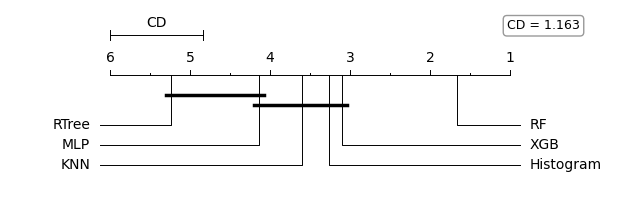

combined + mae + small_datasets


/tmp/ipykernel_2669909/1463458161.py:47: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


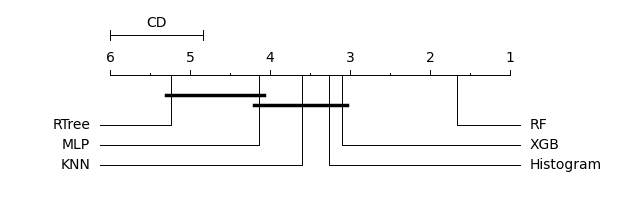

<Figure size 1000x600 with 0 Axes>

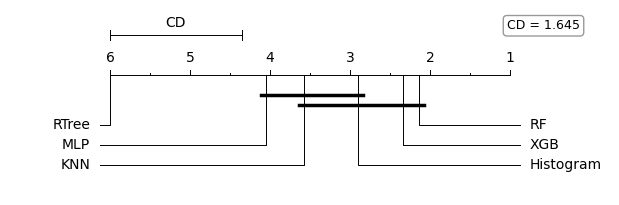

combined + mae + big_datasets


/tmp/ipykernel_2669909/1463458161.py:47: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


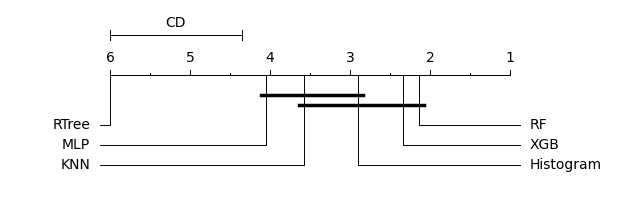

<Figure size 1000x600 with 0 Axes>

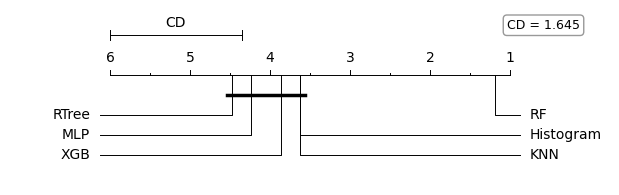

combined + mape + all_datasets


/tmp/ipykernel_2669909/1463458161.py:47: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


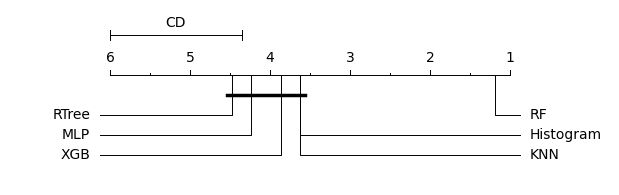

<Figure size 1000x600 with 0 Axes>

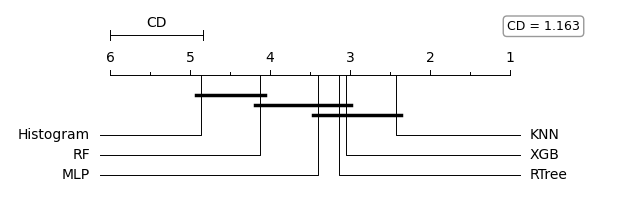

combined + mape + small_datasets


/tmp/ipykernel_2669909/1463458161.py:47: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


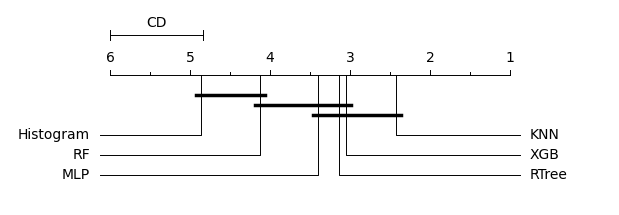

<Figure size 1000x600 with 0 Axes>

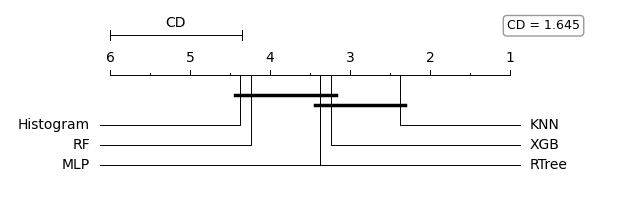

combined + mape + big_datasets


/tmp/ipykernel_2669909/1463458161.py:47: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


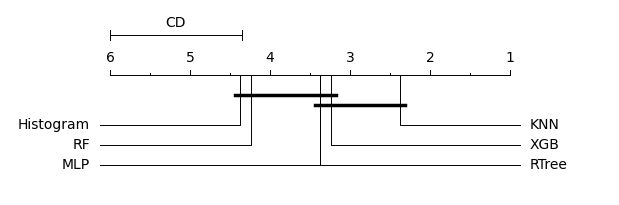

<Figure size 1000x600 with 0 Axes>

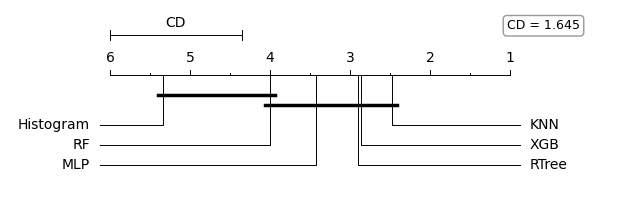

combined + avg_time_ms + all_datasets


/tmp/ipykernel_2669909/1463458161.py:47: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


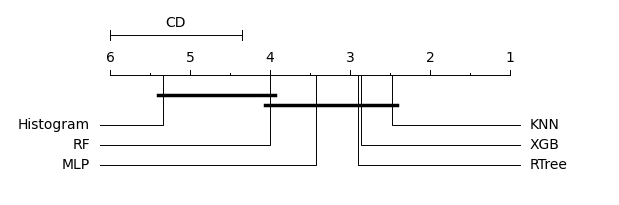

<Figure size 1000x600 with 0 Axes>

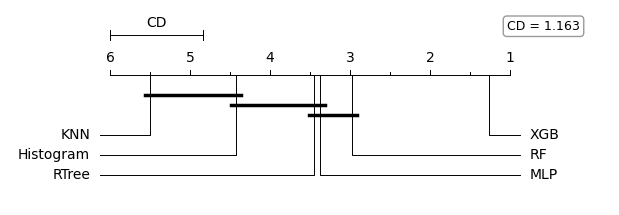

combined + avg_time_ms + small_datasets


/tmp/ipykernel_2669909/1463458161.py:47: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


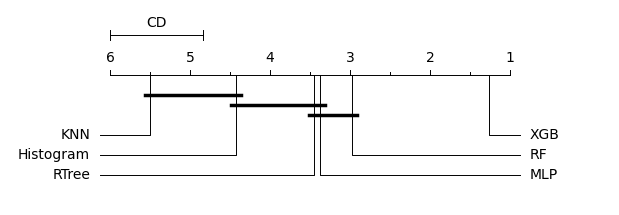

<Figure size 1000x600 with 0 Axes>

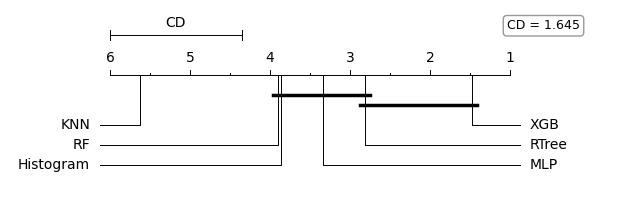

combined + avg_time_ms + big_datasets


/tmp/ipykernel_2669909/1463458161.py:47: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


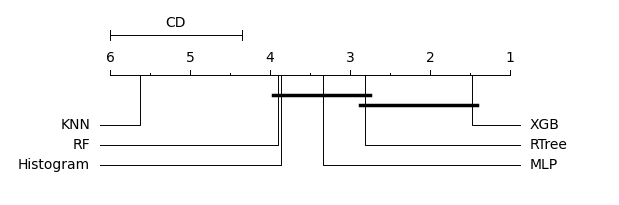

<Figure size 1000x600 with 0 Axes>

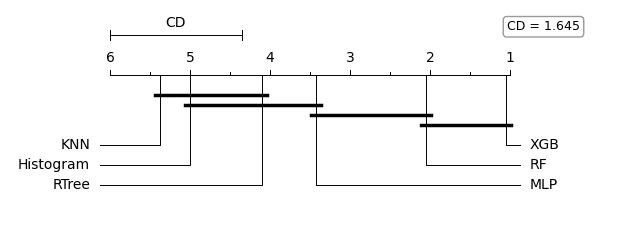

combined + build_time_s + all_datasets


/tmp/ipykernel_2669909/1463458161.py:47: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


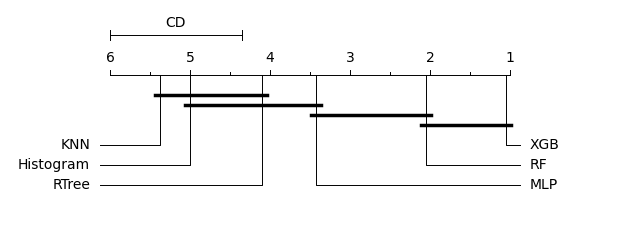

<Figure size 1000x600 with 0 Axes>

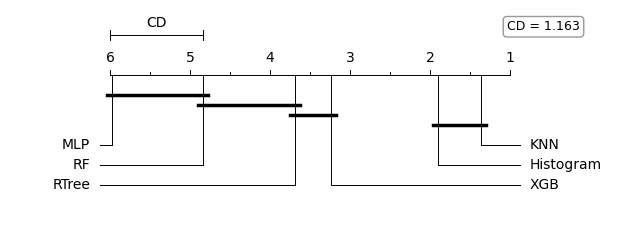

combined + build_time_s + small_datasets


/home/adminlias/anaconda3/envs/analyze_new_env/lib/python3.12/site-packages/autorank/_util.py:114: RuntimeWarning: invalid value encountered in scalar divide
  return (np.median(x) - np.median(y)) / _pooled_mad(x, y)
/tmp/ipykernel_2669909/1463458161.py:47: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


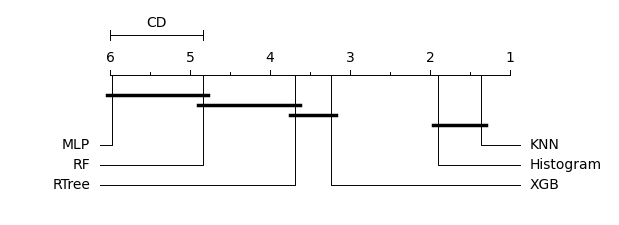

<Figure size 1000x600 with 0 Axes>

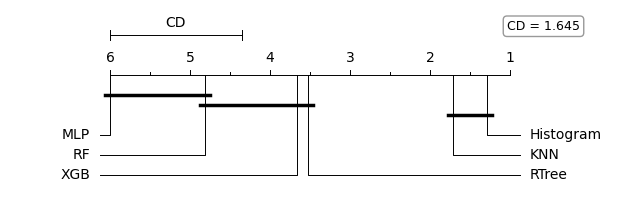

combined + build_time_s + big_datasets


/tmp/ipykernel_2669909/1463458161.py:47: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


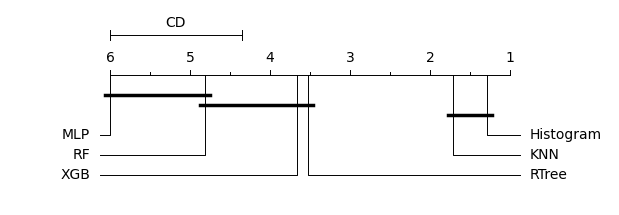

<Figure size 1000x600 with 0 Axes>

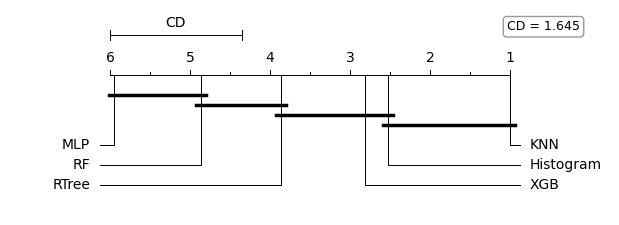

combined + model_size_mb + all_datasets


/tmp/ipykernel_2669909/1463458161.py:47: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


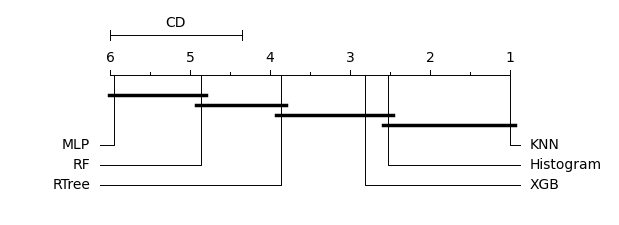

<Figure size 1000x600 with 0 Axes>

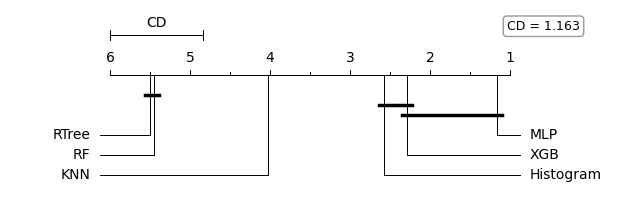

combined + model_size_mb + small_datasets


/tmp/ipykernel_2669909/1463458161.py:47: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


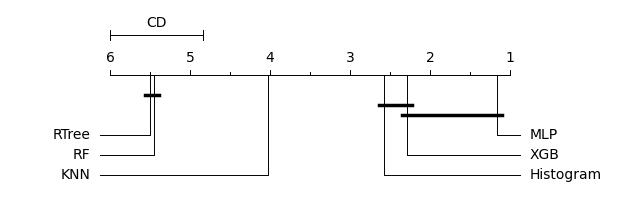

<Figure size 1000x600 with 0 Axes>

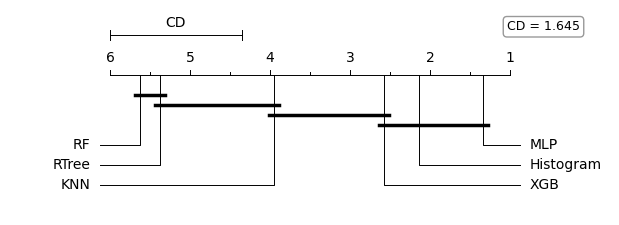

combined + model_size_mb + big_datasets


/tmp/ipykernel_2669909/1463458161.py:47: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


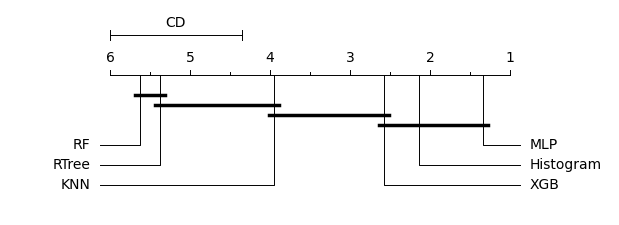

<Figure size 1000x600 with 0 Axes>

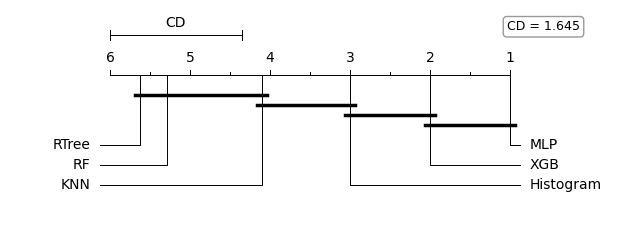

intersect + mae + all_datasets


/tmp/ipykernel_2669909/1463458161.py:47: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


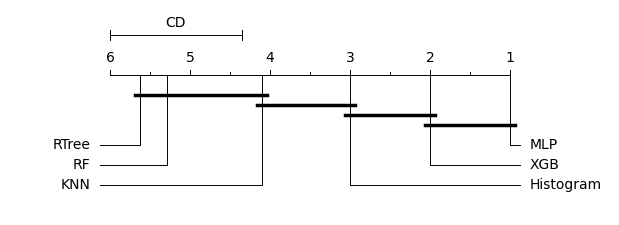

<Figure size 1000x600 with 0 Axes>

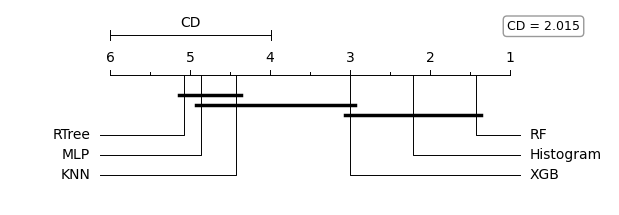

intersect + mae + small_datasets


/tmp/ipykernel_2669909/1463458161.py:47: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


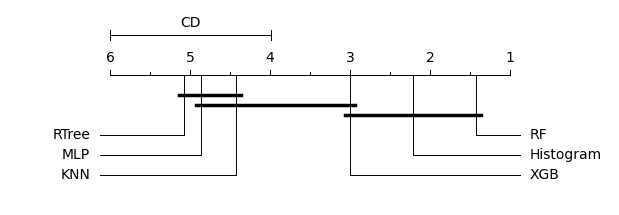

<Figure size 1000x600 with 0 Axes>

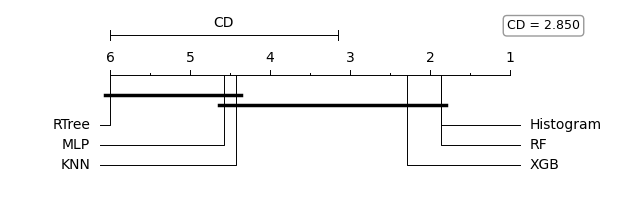

intersect + mae + big_datasets


/tmp/ipykernel_2669909/1463458161.py:47: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


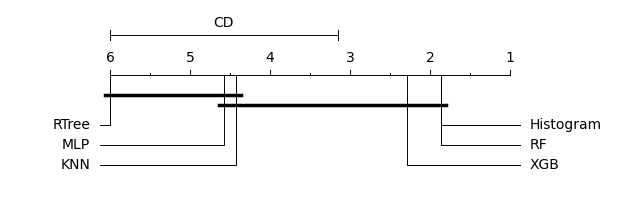

<Figure size 1000x600 with 0 Axes>

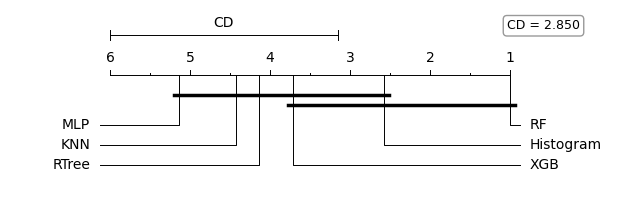

intersect + mape + all_datasets


/tmp/ipykernel_2669909/1463458161.py:47: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


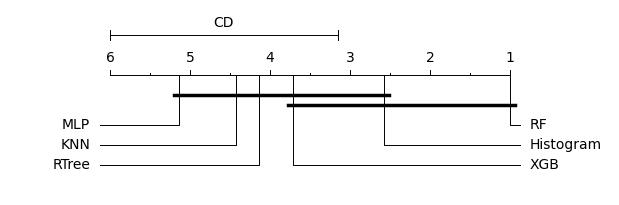

<Figure size 1000x600 with 0 Axes>

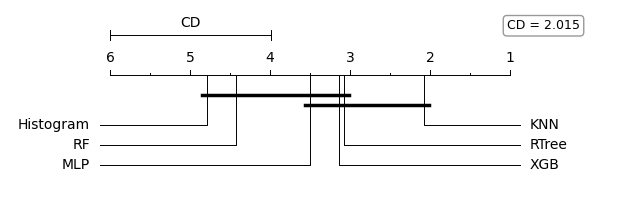

intersect + mape + small_datasets


/tmp/ipykernel_2669909/1463458161.py:47: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


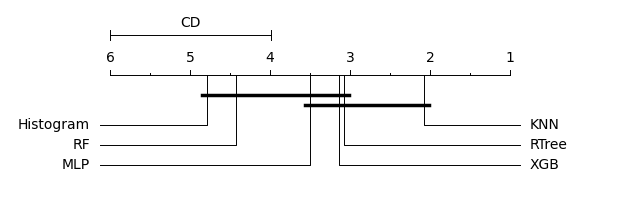

<Figure size 1000x600 with 0 Axes>

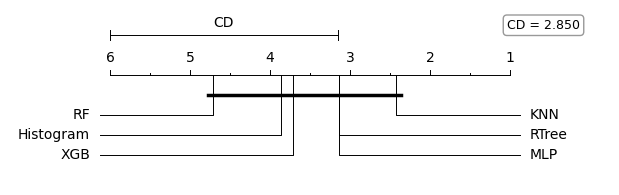

intersect + mape + big_datasets


/tmp/ipykernel_2669909/1463458161.py:47: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


<Figure size 1000x600 with 0 Axes>

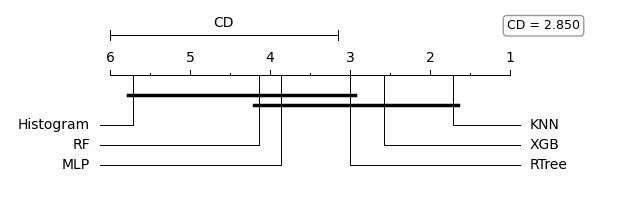

intersect + avg_time_ms + all_datasets


/tmp/ipykernel_2669909/1463458161.py:47: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


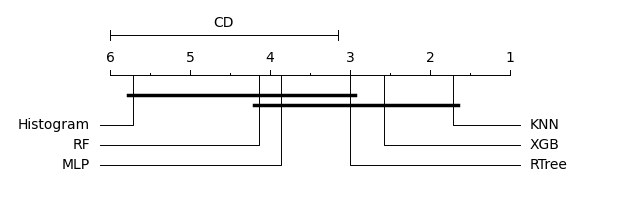

<Figure size 1000x600 with 0 Axes>

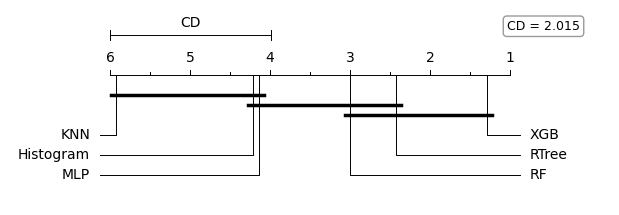

intersect + avg_time_ms + small_datasets


/tmp/ipykernel_2669909/1463458161.py:47: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


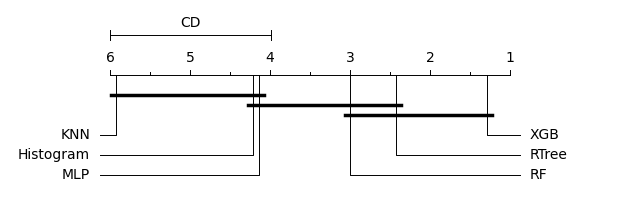

<Figure size 1000x600 with 0 Axes>

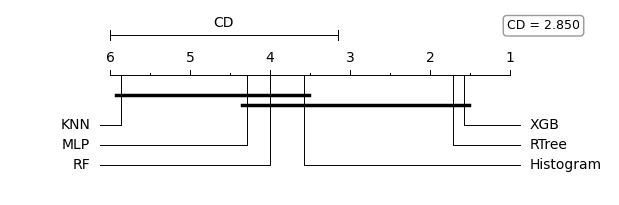

intersect + avg_time_ms + big_datasets


/tmp/ipykernel_2669909/1463458161.py:47: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


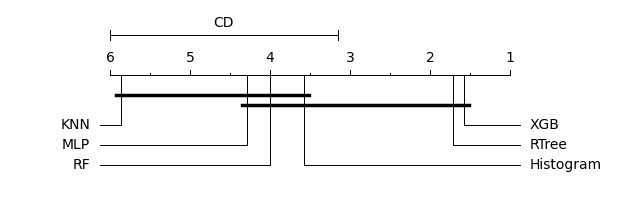

<Figure size 1000x600 with 0 Axes>

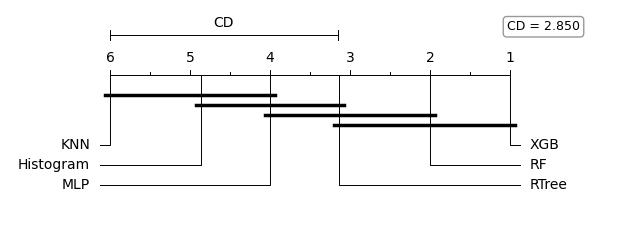

intersect + build_time_s + all_datasets


/tmp/ipykernel_2669909/1463458161.py:47: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


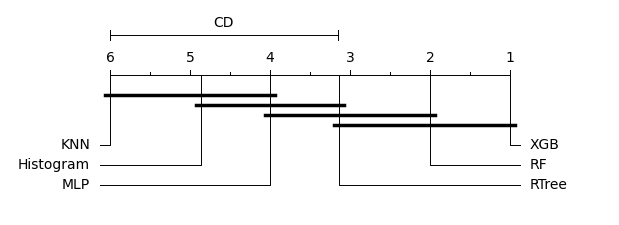

<Figure size 1000x600 with 0 Axes>

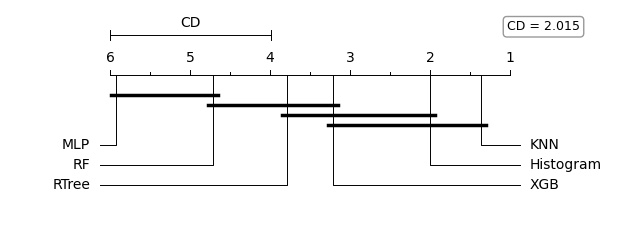

intersect + build_time_s + small_datasets


/home/adminlias/anaconda3/envs/analyze_new_env/lib/python3.12/site-packages/autorank/_util.py:114: RuntimeWarning: invalid value encountered in scalar divide
  return (np.median(x) - np.median(y)) / _pooled_mad(x, y)
/tmp/ipykernel_2669909/1463458161.py:47: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


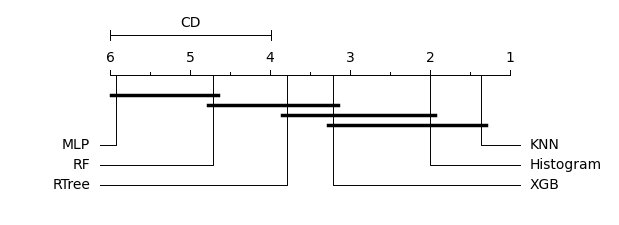

<Figure size 1000x600 with 0 Axes>

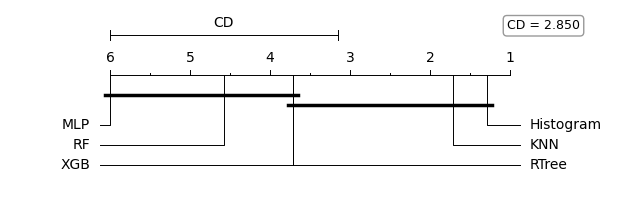

intersect + build_time_s + big_datasets


/tmp/ipykernel_2669909/1463458161.py:47: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


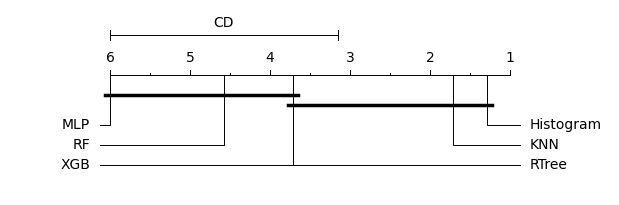

<Figure size 1000x600 with 0 Axes>

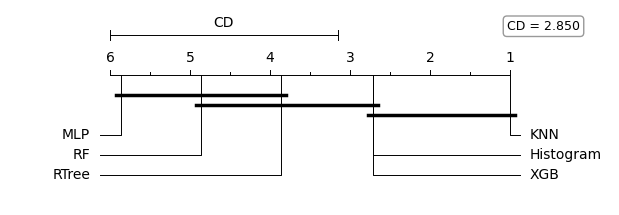

intersect + model_size_mb + all_datasets


/tmp/ipykernel_2669909/1463458161.py:47: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


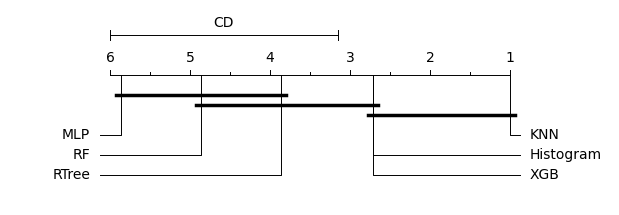

<Figure size 1000x600 with 0 Axes>

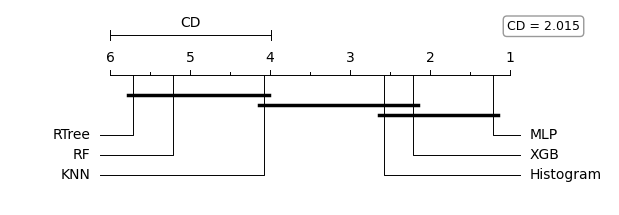

intersect + model_size_mb + small_datasets


/tmp/ipykernel_2669909/1463458161.py:47: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


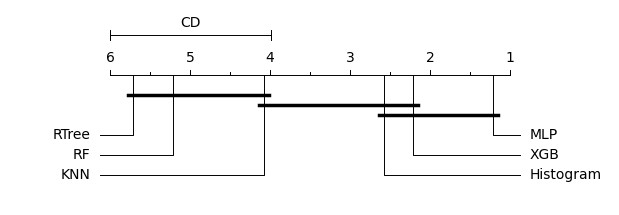

<Figure size 1000x600 with 0 Axes>

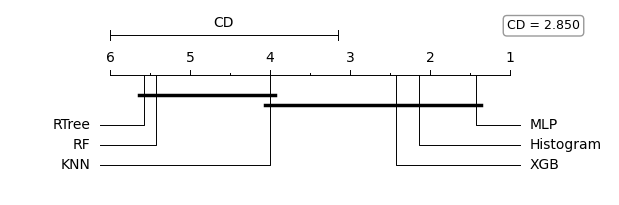

intersect + model_size_mb + big_datasets


/tmp/ipykernel_2669909/1463458161.py:47: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


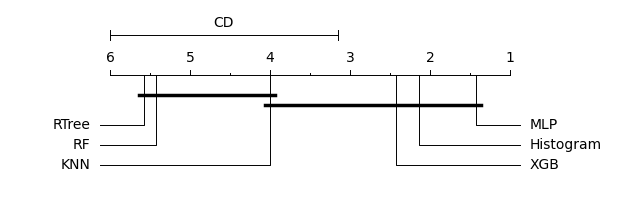

<Figure size 1000x600 with 0 Axes>

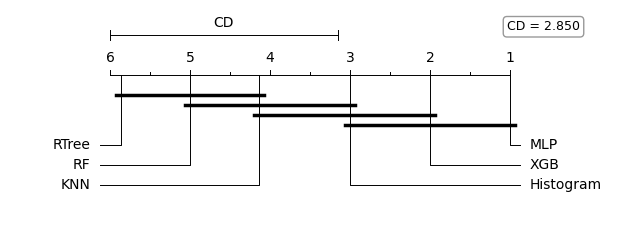

contain + mae + all_datasets


/tmp/ipykernel_2669909/1463458161.py:47: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


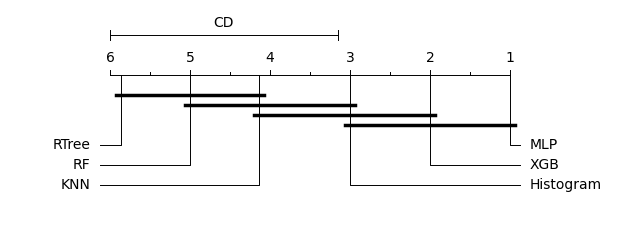

<Figure size 1000x600 with 0 Axes>

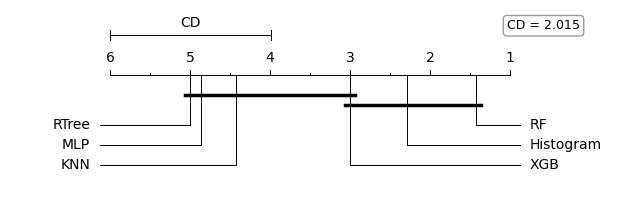

/tmp/ipykernel_2669909/1463458161.py:47: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


contain + mae + small_datasets


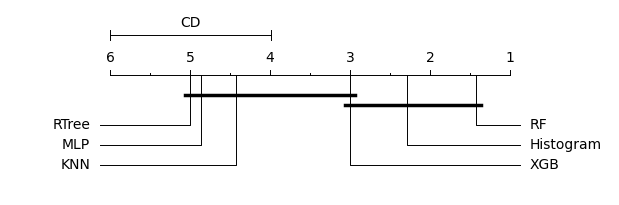

<Figure size 1000x600 with 0 Axes>

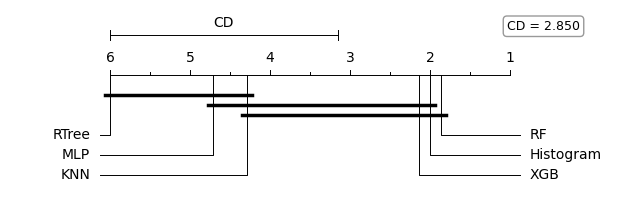

contain + mae + big_datasets


/tmp/ipykernel_2669909/1463458161.py:47: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


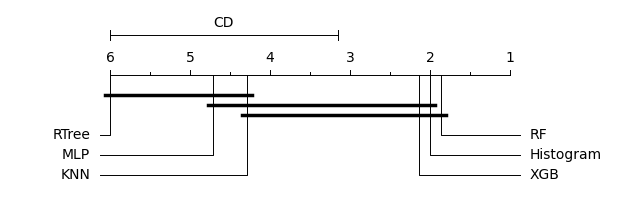

<Figure size 1000x600 with 0 Axes>

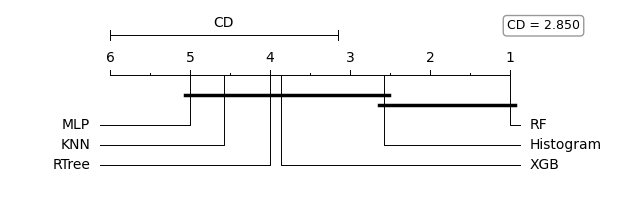

contain + mape + all_datasets


/tmp/ipykernel_2669909/1463458161.py:47: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


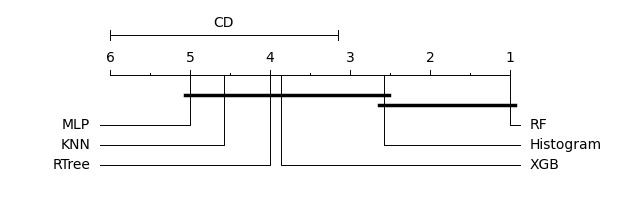

<Figure size 1000x600 with 0 Axes>

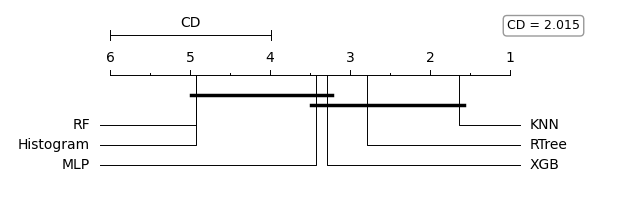

contain + mape + small_datasets


/tmp/ipykernel_2669909/1463458161.py:47: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


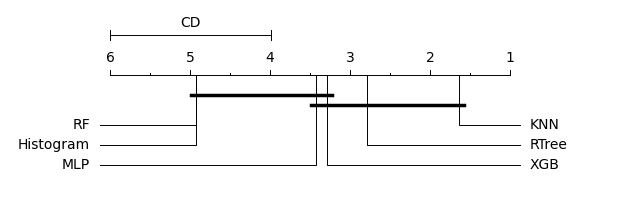

<Figure size 1000x600 with 0 Axes>

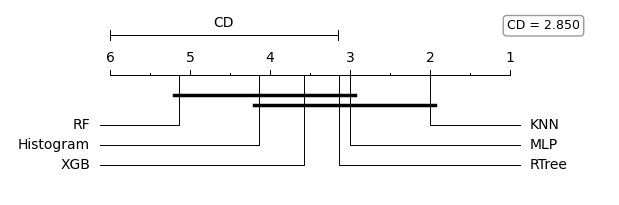

contain + mape + big_datasets


/tmp/ipykernel_2669909/1463458161.py:47: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


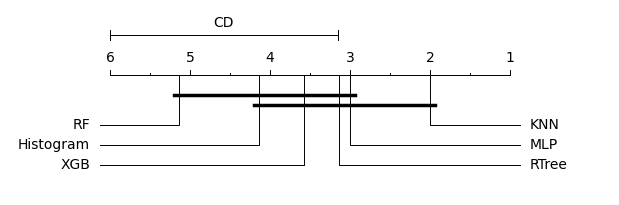

<Figure size 1000x600 with 0 Axes>

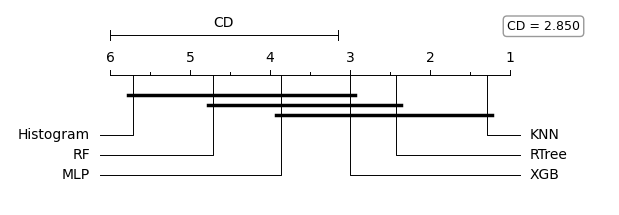

contain + avg_time_ms + all_datasets


/tmp/ipykernel_2669909/1463458161.py:47: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


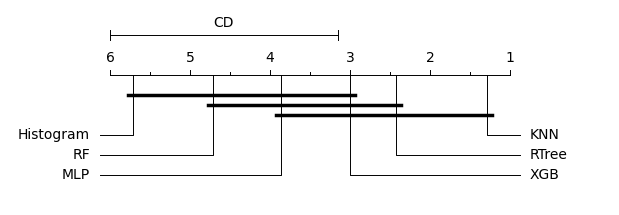

<Figure size 1000x600 with 0 Axes>

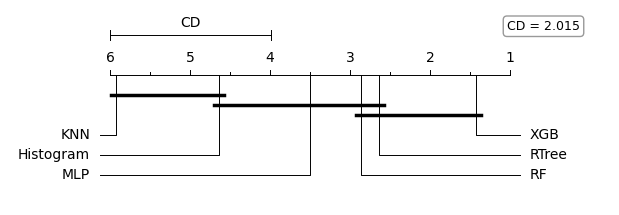

contain + avg_time_ms + small_datasets


/tmp/ipykernel_2669909/1463458161.py:47: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


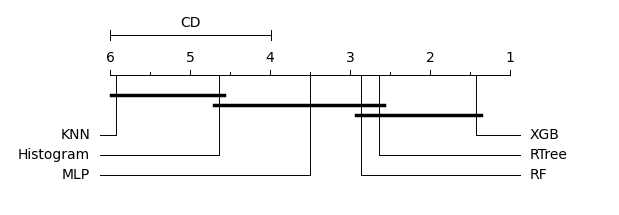

<Figure size 1000x600 with 0 Axes>

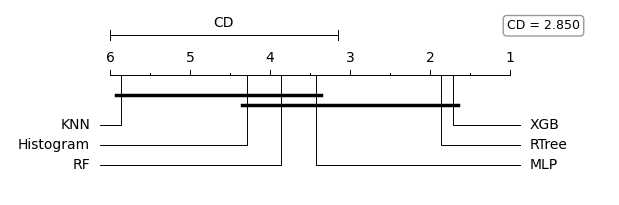

contain + avg_time_ms + big_datasets


/tmp/ipykernel_2669909/1463458161.py:47: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


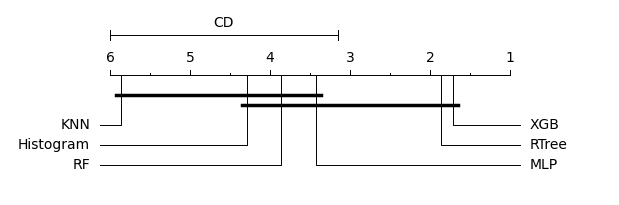

<Figure size 1000x600 with 0 Axes>

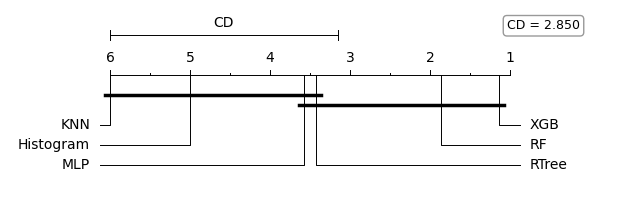

contain + build_time_s + all_datasets


/tmp/ipykernel_2669909/1463458161.py:47: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


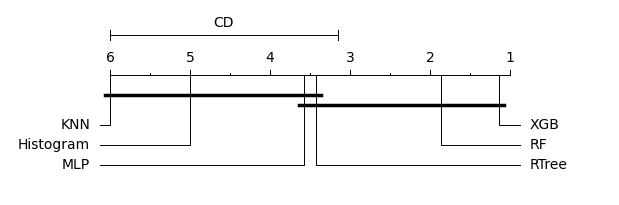

<Figure size 1000x600 with 0 Axes>

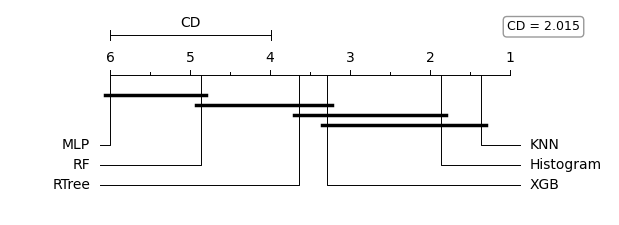

contain + build_time_s + small_datasets


/home/adminlias/anaconda3/envs/analyze_new_env/lib/python3.12/site-packages/autorank/_util.py:114: RuntimeWarning: invalid value encountered in scalar divide
  return (np.median(x) - np.median(y)) / _pooled_mad(x, y)
/tmp/ipykernel_2669909/1463458161.py:47: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


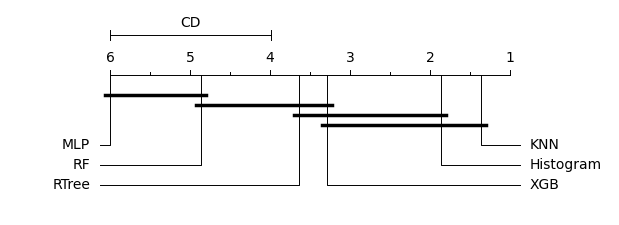

<Figure size 1000x600 with 0 Axes>

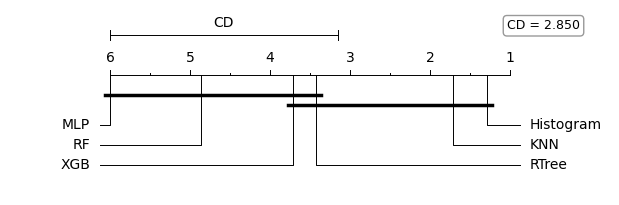

/tmp/ipykernel_2669909/1463458161.py:47: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


contain + build_time_s + big_datasets


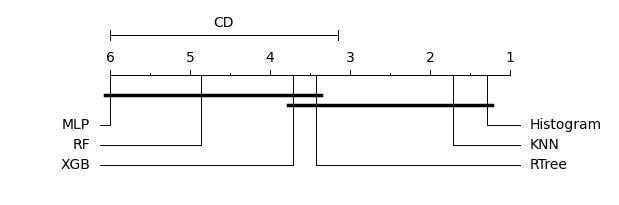

<Figure size 1000x600 with 0 Axes>

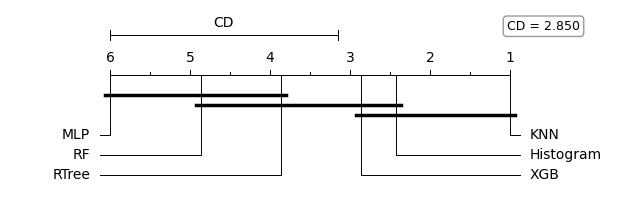

contain + model_size_mb + all_datasets


/tmp/ipykernel_2669909/1463458161.py:47: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


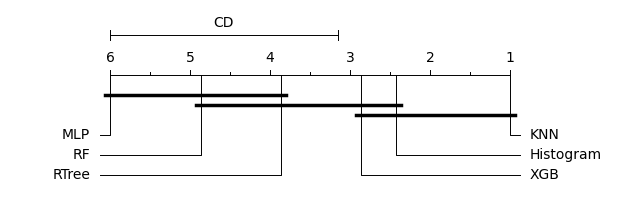

<Figure size 1000x600 with 0 Axes>

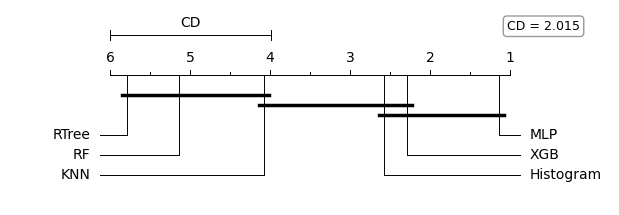

contain + model_size_mb + small_datasets


/tmp/ipykernel_2669909/1463458161.py:47: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


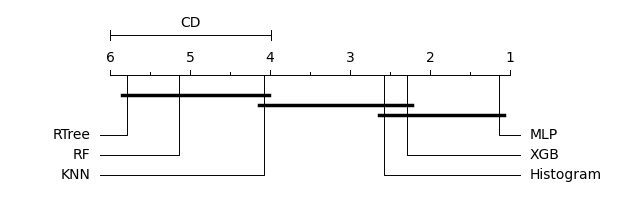

<Figure size 1000x600 with 0 Axes>

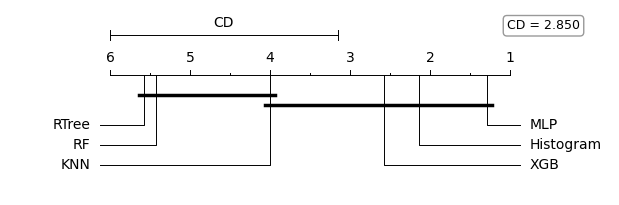

contain + model_size_mb + big_datasets


/tmp/ipykernel_2669909/1463458161.py:47: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


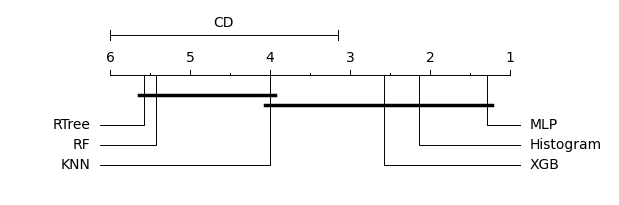

<Figure size 1000x600 with 0 Axes>

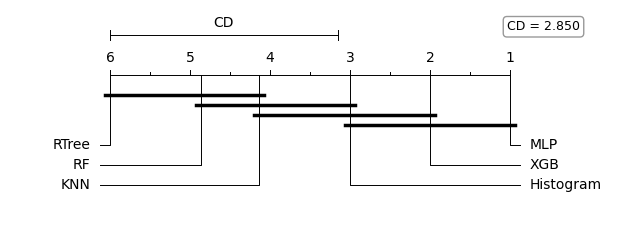

distance + mae + all_datasets


/tmp/ipykernel_2669909/1463458161.py:47: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


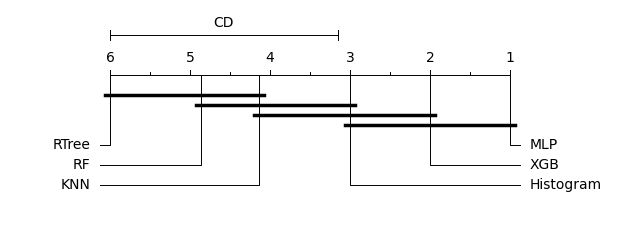

<Figure size 1000x600 with 0 Axes>

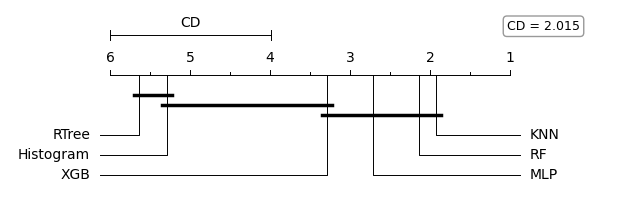

distance + mae + small_datasets


/tmp/ipykernel_2669909/1463458161.py:47: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


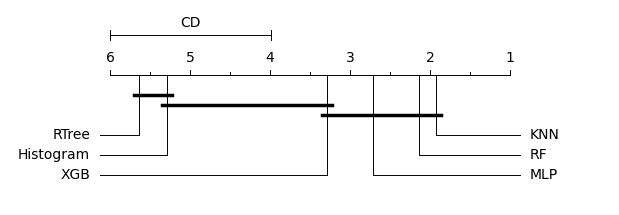

<Figure size 1000x600 with 0 Axes>

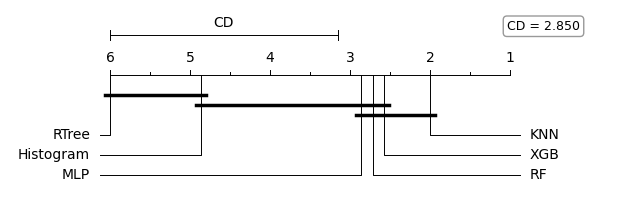

distance + mae + big_datasets


/tmp/ipykernel_2669909/1463458161.py:47: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


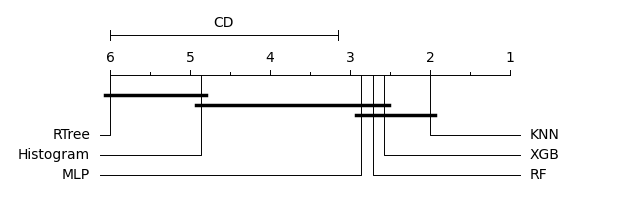

<Figure size 1000x600 with 0 Axes>

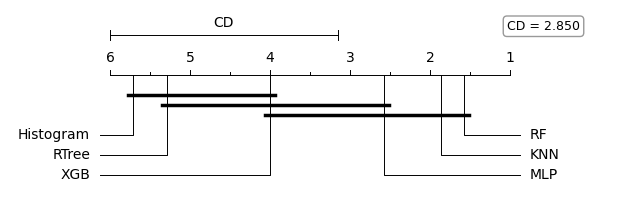

distance + mape + all_datasets


/tmp/ipykernel_2669909/1463458161.py:47: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


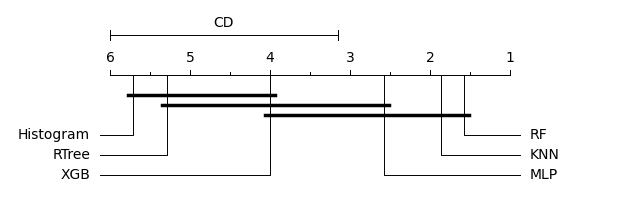

<Figure size 1000x600 with 0 Axes>

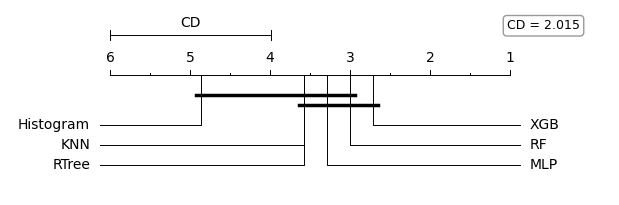

distance + mape + small_datasets


/tmp/ipykernel_2669909/1463458161.py:47: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


<Figure size 1000x600 with 0 Axes>

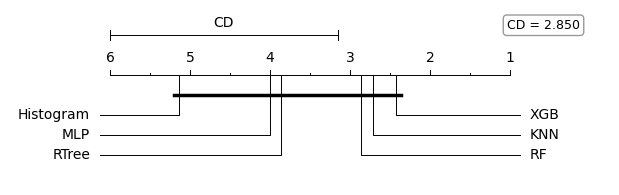

distance + mape + big_datasets


/tmp/ipykernel_2669909/1463458161.py:47: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


<Figure size 1000x600 with 0 Axes>

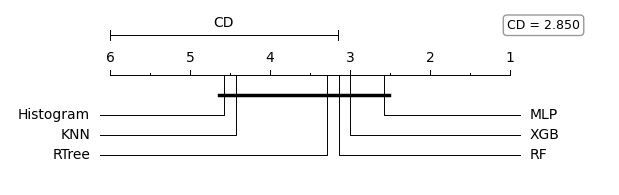

distance + avg_time_ms + all_datasets


/tmp/ipykernel_2669909/1463458161.py:47: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


<Figure size 1000x600 with 0 Axes>

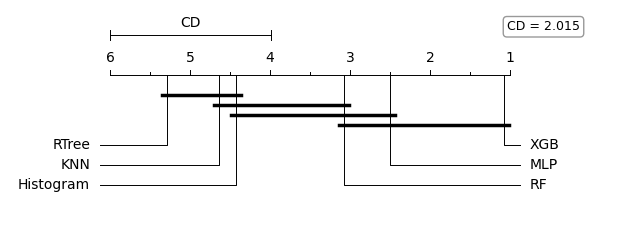

distance + avg_time_ms + small_datasets


/tmp/ipykernel_2669909/1463458161.py:47: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


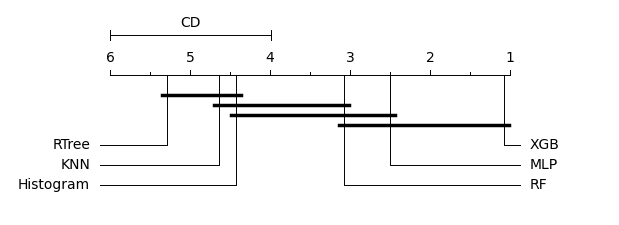

<Figure size 1000x600 with 0 Axes>

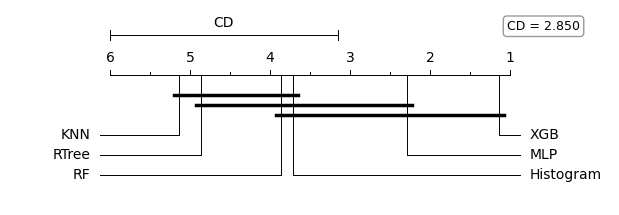

distance + avg_time_ms + big_datasets


/tmp/ipykernel_2669909/1463458161.py:47: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


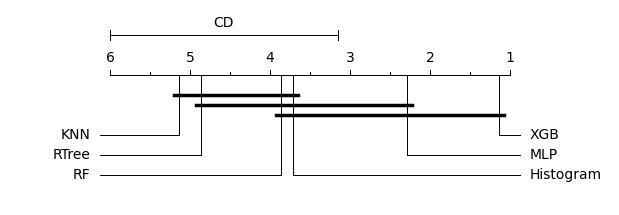

<Figure size 1000x600 with 0 Axes>

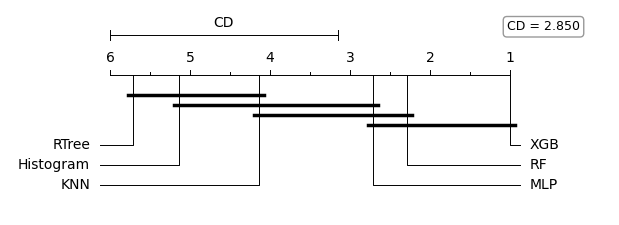

distance + build_time_s + all_datasets


/tmp/ipykernel_2669909/1463458161.py:47: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


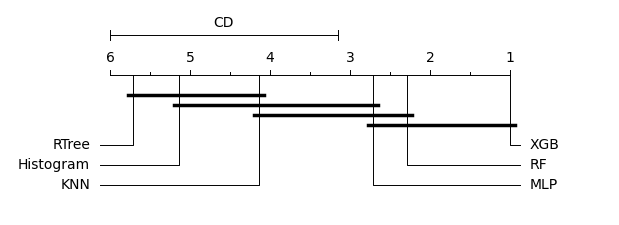

<Figure size 1000x600 with 0 Axes>

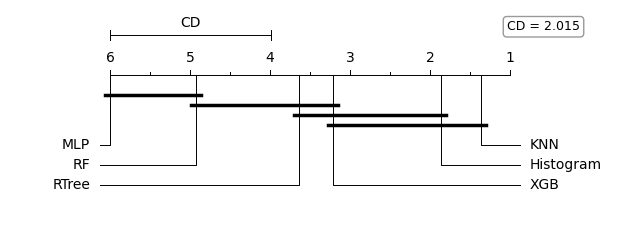

/home/adminlias/anaconda3/envs/analyze_new_env/lib/python3.12/site-packages/autorank/_util.py:114: RuntimeWarning: invalid value encountered in scalar divide
  return (np.median(x) - np.median(y)) / _pooled_mad(x, y)
/tmp/ipykernel_2669909/1463458161.py:47: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


distance + build_time_s + small_datasets


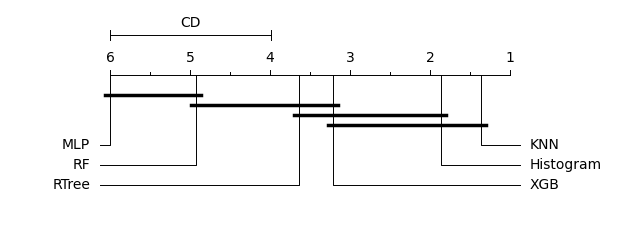

<Figure size 1000x600 with 0 Axes>

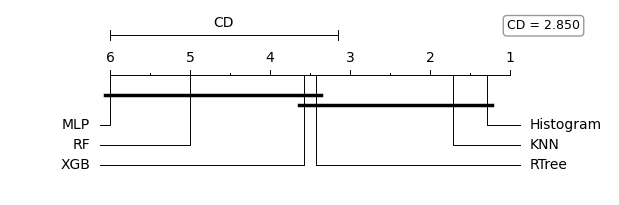

distance + build_time_s + big_datasets


/tmp/ipykernel_2669909/1463458161.py:47: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


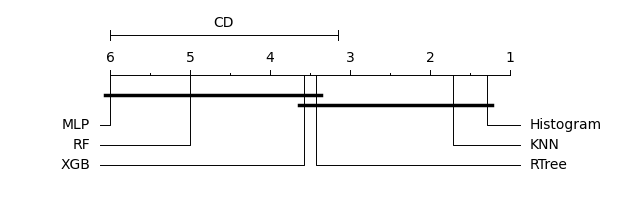

<Figure size 1000x600 with 0 Axes>

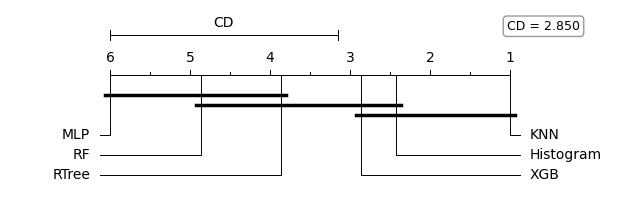

distance + model_size_mb + all_datasets


/tmp/ipykernel_2669909/1463458161.py:47: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


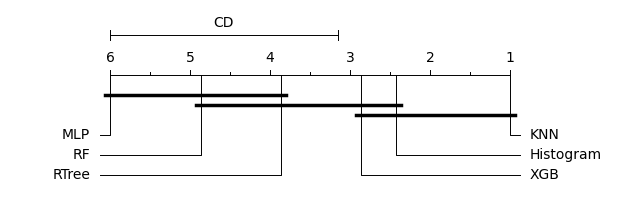

<Figure size 1000x600 with 0 Axes>

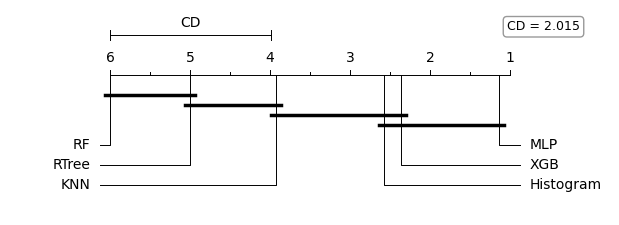

distance + model_size_mb + small_datasets


/tmp/ipykernel_2669909/1463458161.py:47: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


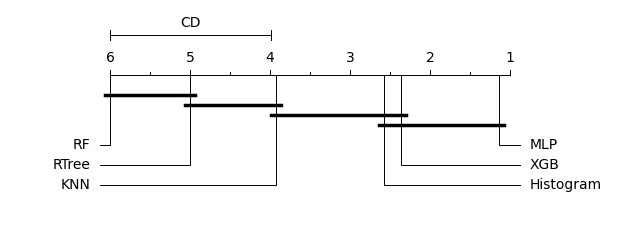

<Figure size 1000x600 with 0 Axes>

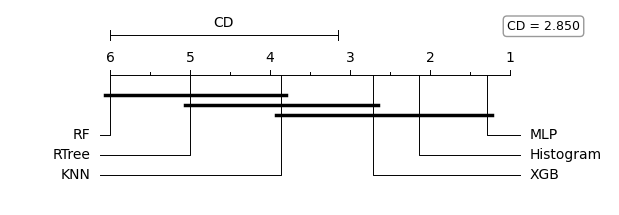

distance + model_size_mb + big_datasets


/tmp/ipykernel_2669909/1463458161.py:47: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


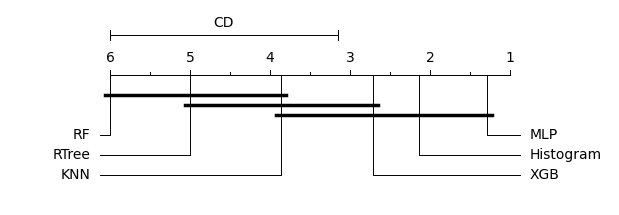

<Figure size 1000x600 with 0 Axes>

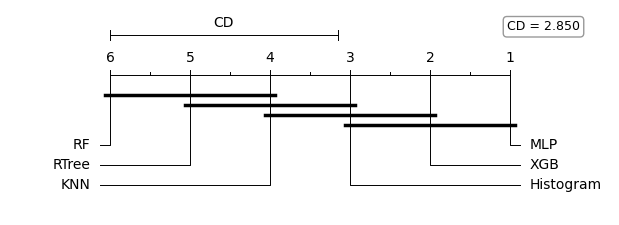

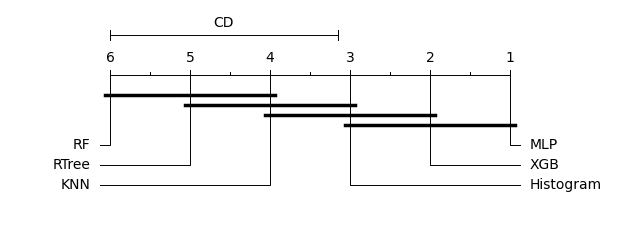

In [10]:
#combined (filters)
for metric in metrics:
    print(f"combined + {metric} + all_datasets")
    nemenyi_diagrams(models, filters, "combined", datasets, metric, "../model_comparison copy.json", "nemenyi_diagrams/all_datasets")
    print(f"combined + {metric} + small_datasets")
    nemenyi_diagrams(models, filters, "combined", small_datasets, metric, "../model_comparison copy.json", "nemenyi_diagrams/small_datasets")
    print(f"combined + {metric} + big_datasets")
    nemenyi_diagrams(models, filters, "combined", big_datasets, metric, "../model_comparison copy.json", "nemenyi_diagrams/big_datasets")

#individual (filters)
for filter in filters:
    for metric in metrics:
        print(f"{filter} + {metric} + all_datasets")
        nemenyi_diagrams(models, [filter], filter, datasets, metric, "../model_comparison copy.json", f"nemenyi_diagrams/all_datasets")
        print(f"{filter} + {metric} + small_datasets")
        nemenyi_diagrams(models, [filter], filter, small_datasets, metric, "../model_comparison copy.json", f"nemenyi_diagrams/small_datasets")
        print(f"{filter} + {metric} + big_datasets")
        nemenyi_diagrams(models, [filter], filter, big_datasets, metric, "../model_comparison copy.json", f"nemenyi_diagrams/big_datasets")